GenJAX is a swiss army knife for probabilistic machine learning: it's designed to support probabilistic modeling workflows, and to make the resulting code extremely fast and parallelizable via JAX.

In this introduction, we'll focus on one such workflow: writing a latent variable model (we often say: a generative model) which describes a probability distribution over latent variables and data, and then asking questions about the conditional distribution over the latent variables given data.

In the following, we'll often shorten GenJAX to Gen -- because [GenJAX implements Gen](https://www.gen.dev/).


In [1]:
import genjax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import gen.studio.plot as Plot
from genjax import gen, normal, pretty
from jax import jit, vmap
from jax import random as jrand

sns.set_theme(style="white")
plt.rcParams["figure.facecolor"] = "none"
plt.rcParams["savefig.transparent"] = True
%config InlineBackend.figure_format = 'svg'

pretty()  # pretty print the types

## Generative functions 

In [2]:
@gen
def model():
    x = normal(0.0, 1.0) @ "x"
    normal(x, 1.0) @ "y"


model

StaticGenerativeFunction(...)

In Gen, probabilistic models are represented by a computational object called _a generative function_. Once we create one of these objects, we can use one of several interfaces to gain access to probabilistic effects.

Here's one interface: `simulate` -- this samples from the probability distribution which the program represents, and stores the result, along with other data about the invocation of the function, in a data structure called a `Trace`.

In [3]:
key = jrand.PRNGKey(0)
tr = model.simulate(key, ())
tr

StaticTrace(...)

We can dig around in this object uses its interfaces:

In [4]:
chm = tr.get_sample()
chm

ChoiceMap(...)

A `ChoiceMap` is a representation of _the sample_ from the probability distribution which the generative function represents. We can ask _what values were sampled_ at the addresses (the `"x"` and `"y"` syntax in our model):

In [5]:
(chm["x"], chm["y"])

(<jax.Array(-1.2515389, dtype=float32)>,
 <jax.Array(-1.8381894, dtype=float32)>)

Neat -- all of our interfaces are JAX compatible, so we could sample 1000 times just by using `jax.vmap`:

In [6]:
sub_keys = jrand.split(jrand.PRNGKey(0), 1000)
tr = jit(vmap(model.simulate, in_axes=(0, None)))(sub_keys, ())
tr

StaticTrace(...)

Let's plot our samples to get a sense of the distribution we wrote down.

In [7]:
chm = tr.get_sample()
Plot.dot({"x": chm["x"], "y": chm["y"]})

Widget(data={'pyobsplot-type': 'function', 'module': 'View', 'name': 'PlotSpec', 'args': ({'width': 500, 'heig…

Traces also keep track of other data, like _the score_ of the execution (which is a value which estimates the joint probability of the random choices under the distribution):

In [8]:
tr.get_score()

<jax.Array float64(1000,) ≈-2.9 ±0.97 [≥-8.3, ≤-1.8] nonzero:1_000
  <Arrayviz rendering>
>

## Composition of generative functions

Generative functions are probabilistic building blocks. You can combine them into larger probability distributions:

In [9]:
# A regression distribution.
@gen
def regression(x, coefficients, sigma):
    basis_value = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(basis_value * coefficients)
    y = genjax.normal(polynomial_value, sigma) @ "v"
    return y


# Regression, with an outlier random variable.
@gen
def regression_with_outlier(x, coefficients):
    is_outlier = genjax.flip(0.1) @ "is_outlier"
    sigma = jnp.where(is_outlier, 30.0, 0.3)
    is_outlier = jnp.array(is_outlier, dtype=int)
    return regression(x, coefficients, sigma) @ "y"


# The full model, sample coefficients for a curve, and then use
# them in independent draws from the regression submodel.
@gen
def full_model(xs):
    coefficients = (
        genjax.mv_normal(
            jnp.zeros(3, dtype=float),
            2.0 * jnp.identity(3),
        )
        @ "alpha"
    )
    ys = regression_with_outlier.vmap(in_axes=(0, None))(xs, coefficients) @ "ys"
    return ys

Now, let's examine a sample from this model:

In [10]:
data = jnp.arange(0, 10, 0.5)
full_model.simulate(key, (data,)).get_sample()["ys", ..., "y", "v"]

<jax.Array float64(20,) ≈-7.3e+01 ±7e+01 [≥-2.1e+02, ≤5.7e+01] nonzero:20
  <Arrayviz rendering>
>

We can plot a few such samples.

In [11]:
key, *sub_keys = jrand.split(key, 10)
traces = vmap(lambda k: full_model.simulate(k, (data,)))(jnp.array(sub_keys))
Plot.small_multiples([
    Plot.dot({"x": data, "y": ys}) for ys in traces.get_sample()["ys", ..., "y", "v"]
])

Widget(data=['div.grid.black', {'style': {'display': 'grid', 'grid-template-columns': 'repeat(auto-fit, minmax…

These are samples from the distribution _over curves_ which our generative function represents.

## Inference in generative functions

So we've written a regression model, a distribution over curves. Our model includes an outlier component. If we observe some data for `"y"`, can we predict which points might be outliers?

In [12]:
x = jnp.array([0.3, 0.7, 1.1, 1.4, 2.3, 2.5, 3.0, 4.0, 5.0])
y = 2.0 * x + 1.5 + x**2
y = y.at[2].set(50.0)
y

<Array([ 2.19,  3.39, 50.  ,  6.26, 11.39, 12.75, 16.5 , 25.5 , 36.5 ],      dtype=float64)
  <Arrayviz rendering>
>

We've explored how generative functions represent joint distributions over random variables, but what about distributions induced by inference problems?

We can create an inference problem by pairing a generative function with arguments, and _a constraint_.

First, let's learn how to create one type of constraint -- a _choice map_ sample, just like the choice maps we saw earlier.

In [13]:
from genjax import ChoiceMapBuilder as C

chm = vmap(lambda idx, v: C["ys", idx, "y", "v"].set(v))(jnp.arange(len(y)), y)
chm["ys", ..., "y", "v"]

<Array([ 2.19,  3.39, 50.  ,  6.26, 11.39, 12.75, 16.5 , 25.5 , 36.5 ],      dtype=float64)
  <Arrayviz rendering>
>

The choice map holds the _value constraint_ for the distributions we used in our generative function. Choice maps are a lot like arrays, with a bit of extra metadata.

Now, we can specify an inference target.

In [14]:
from genjax import Target

target = Target(full_model, (x,), chm)
target

Target(...)

A `Target` represents an unnormalized distribution -- in this case, the posterior of the distribution represented by our generative function with arguments `args = (x, )`.

Now, we can approximate the solution to the inference problem using an inference algorithm. GenJAX exposes a standard library of approximate inference algorithms: let's use $K$-particle importance sampling for this one.

In [15]:
from genjax.inference.smc import ImportanceK

alg = ImportanceK(target, k_particles=100)
alg

ImportanceK(...)

In [16]:
sub_keys = jrand.split(key, 50)
posterior_samples = jit(vmap(alg(target)))(sub_keys)

TypeError: true_fun and false_fun output must have identical types, got
('ShapedArray(float32[])', 'DIFFERENT ShapedArray(float32[]) vs. ShapedArray(float64[], weak_type=True)', 'ShapedArray(int32[])').

With samples from our approximate posterior in hand, we can check queries like "estimate the probability that a point is an outlier":

In [17]:
posterior_samples["ys", ..., "is_outlier"]

NameError: name 'posterior_samples' is not defined

Here, we see that our approximate posterior assigns high probability to the query "the 3rd data point is an outlier". Remember, we set this point to be far away from the other points.

In [18]:
posterior_samples["ys", ..., "is_outlier"].mean(axis=0)

NameError: name 'posterior_samples' is not defined

We can also plot the sampled curves against the data.

NameError: name 'viz' is not defined

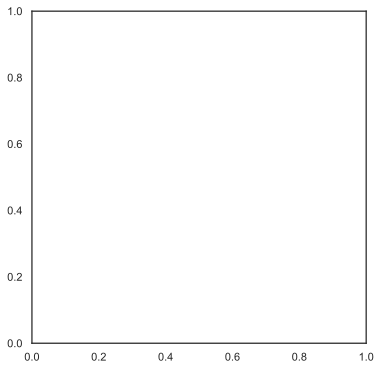

In [19]:
def polynomial_at_x(x, coefficients):
    basis_values = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(coefficients * basis_values)
    return polynomial_value

jitted = jit(vmap(polynomial_at_x, in_axes=(None, 0)))

coefficients = posterior_samples["alpha"]
evaluation_points = jnp.arange(0, 5, 0.01)

points = [(x, y) for x in evaluation_points for y in jitted(x, coefficients).tolist()]
Plot.dot(points, fill="gold", opacity=0.25, r=0.5) + Plot.dot({"x": x, "y": y}) + Plot.frame()

## Summary

We’ve covered a lot of ground in this notebook. Please reflect, re-read, and post issues!

* We discussed generative functions - the main computational object of Gen, and how these objects represent probability distributions.
* We showed how to create generative functions.
* We showed how to use interfaces on generative functions to compute with common operations on distributions.
* We created a generative function to model a data-generating process based on sampling and evaluating random polynomials on input data - representing regression task.
* We showed how to create _inference problems_ from generative functions.
* We created an inference problem from our regression model.
* We showed how to create approximate inference solutions to inference problems, and sample from them.
* We investigated the approximate posterior samples, and visually inspected that they match the inferences that we might draw - both for the polynomials we expected to produce the data, as well as what data points might be outliers.

This is just the beginning! There’s a lot more to learn, but this is plenty to chew (for now).
